<a href="https://colab.research.google.com/github/LucaMagini/Data-Science/blob/master/5Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Transfer Learning

**What is Transfer Learning?**  

*Transfer Learning* is the reuse of a pre-trained model on a new problem, the knowledge of an already trained machine learning model is applied to a different but related problem. We basically try to exploit what has been learned in one task to improve generalization in another: we transfer the weights thata a network has learned at "task A" to a new "task B".  

The general idea is to use the knowledge a model has learned from a task with a lot of available labeled training data in a new task that doesn't have much data. Instead of starting the learning process from scratch, we start with patterns learned from solving a related task.  
It's mostly used in tasks that require a huge amount of computational power (computer vision, natural language processing).  

<br/>

**Why use Transfer Learning?**  

*Transfer Learning* has several benefits, but the main advantages are:  

  *  Saving training time
  *  Better performance of the NN
  *  Not needing a lot of data  

Usually a lot of data is needed to train a neural netowrk from scratch but access to that data isn't always available. Additionally, training time is reduced because it can sometimes take days or even weeks to train a deep neural network from scratch on a complex task.  

<br/>

**When to use Transfer Learning?**  

As is always the case in machine learning, it is hard to form rules that are generally applicable, but here are some guidelines on when transfer learning might be used:  

  *  There isn't enough labeled training data to train your network from scratch
  *  There already exists a network that is pre-trained on a similar task, which is usually trained on massive amounts of data
  *  When task "A" and task "B" have the same input  

<br/>

There a lot of popular pre-trained models, for example in open-source library like *Tensorflow*, and we can simply restore them and retrain some layers for our task.  The input of the model needs to have the same size as it was initially trained with.  

In this notebook we'll apply this technique trying some of the most popular models in tensorflow, looking for a model that give us a better results than the previous notebooks.

## Data Preparation

In [ ]:
#Importing the libraries
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, shutil
from zipfile import ZipFile
from tabulate import tabulate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from keras.applications import vgg16
from keras.models import Model 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

In [ ]:
#Mounting the Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#Google Colab Version
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

Thu Oct 20 07:55:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#Unzipping all the datasets
train_augmented_path = '/content/drive/MyDrive/Age_Detection_Project/Data/Train_Augmented.zip'
dev_test_path = '/content/drive/MyDrive/Age_Detection_Project/Data/Dev_Test.zip'

paths = [train_augmented_path,  dev_test_path]

for path in paths:         
    with ZipFile(path, 'r') as myzip:
        myzip.extractall('../content/{}'.format(path.split('/')[-1].split('.')[0]))
        print('Done unzipping {}'.format(path.split('/')[-1]))

Done unzipping Train_Augmented.zip
Done unzipping Dev_Test.zip


In [ ]:
#Naming the folders containing data
train_augmented_folder = '../content/Train_Augmented'
dev_test_folder = '../content/Dev_Test'

In [ ]:
#Creating train, validation and test datasets
batch_size = 256
num_classes = 8
epochs = 30
input_shape = (224, 224, 3)

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_augmented_folder,
  validation_split=None,
  subset=None, #If should be return the training set (80%) or the validation set (20%)
  seed=41, #Seed should guarantee that train_ds and val_ds doesn't have common images
  shuffle=True,
  image_size=(224, 224),
  batch_size=batch_size
  )

val_ds = tf.keras.utils.image_dataset_from_directory(
  dev_test_folder,
  validation_split=None,
  subset=None,
  seed=41, 
  shuffle=True,
  image_size=(224, 224),
  batch_size=batch_size
  )

test_dataset = val_ds.take(20)
val_ds = val_ds.skip(20)

print('Batches for training -->', train_ds.cardinality())
print('Batches for validating -->', val_ds.cardinality())
print('Batches for testing -->', test_dataset.cardinality())

Found 166026 files belonging to 8 classes.
Found 10166 files belonging to 8 classes.
Batches for training --> tf.Tensor(649, shape=(), dtype=int64)
Batches for validating --> tf.Tensor(20, shape=(), dtype=int64)
Batches for testing --> tf.Tensor(20, shape=(), dtype=int64)


In [ ]:
#Defining a function to plot the model results
def plot_model_stats(train_loss, val_loss, train_accuracy, val_accuracy, title):
    fig, ax = plt.subplots(ncols=2, figsize=(15,7))

    ax = ax.ravel()

    ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
    ax[0].plot(val_loss, label='Validation Loss', color = 'orangered', marker='o', markersize=5)

    ax[0].set_xlabel('Epochs', fontsize=14)
    ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)

    ax[0].legend(fontsize=14)
    ax[0].tick_params(axis='both', labelsize=12)

    ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
    ax[1].plot(val_accuracy, label='Validation Accuracy', color='orangered', marker='o', markersize=5)

    ax[1].set_xlabel('Epochs', fontsize=14)
    ax[1].set_ylabel('Accuracy', fontsize=14)

    ax[1].legend(fontsize=14)
    ax[1].tick_params(axis='both', labelsize=12)

    fig.suptitle(x=0.5, y=0.94, t=title, fontsize=16)

## VGG-16

**VGG Net** is the name of a pre-trained convolutional neural network (CNN) invented by *Simonyan* and *Zisserman* from *Visual Geometry Group* (VGG) at University of Oxford in 2014 and it was able to be the 1st runner-up of the ILSVRC (ImageNet Large Scale Visual Recognition Competition) 2014 in the classification task. **VGG Net** has been trained on ImageNet ILSVRC data set which include images of 1000 classes split into three sets of 1.3 million training images, 100,000 testing images and 50,000 validation images.

**VGG Net** has learned to extract the features (feature extractor) that can distinguish the objects and is used to classify unseen objects and it was invented with the purpose of enhancing classification accuracy by increasing the depth of the CNNs. **VGG16** has 16 layers and it takes input of 224×224 RGB images and passes them through a stack of convolutional layers with the fixed filter size of 3×3 and the stride of 1. There are five max pooling filters embedded between convolutional layers in order to down-sample the input representation (image, hidden-layer output matrix, etc.). The stack of convolutional layers are followed by 3 fully connected layers, having 4096, 4096 and 1000 channels, respectively. The last layer is a soft-max layer.

In [ ]:
#Importing the VGG-16 pre-trained model
VGG_16 = VGG16(weights='imagenet', include_top=False, input_shape=input_shape, classes=num_classes)

for layers in VGG_16.layers:
    layers.trainable=False

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
#Defining the final layers of the model
vgg16 = Flatten()(VGG_16.output)
vgg16 = Dense(1024,activation='relu')(vgg16)
vgg16 = Dense(512,activation='relu')(vgg16)
vgg16 = Dense(128,activation='relu')(vgg16)
vgg16 = Dense(64,activation='relu')(vgg16)
vgg16 = Dropout(0.5)(vgg16)
vgg16 = Dense(8,activation='softmax')(vgg16)
vgg16_final_model = Model(inputs=VGG_16.input, outputs=vgg16)
vgg16_final_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])

vgg16_final_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
#Training the model & saving weights
number_of_epochs = 50
vgg16_filepath = '../content/vgg16_weights.h5'
vgg16_checkpoint = tf.keras.callbacks.ModelCheckpoint(vgg16_filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min') #val_acc & max is another possibility
vgg16_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.000002)
callbacklist = [vgg16_checkpoint, vgg16_early_stopping, reduce_lr]
vgg16_history = vgg16_final_model.fit(train_ds, epochs = number_of_epochs, validation_data = val_ds, callbacks=callbacklist, verbose=1)

Epoch 1/50
649/649 [==============================] - ETA: 0s - loss: 2.0748 - sparse_categorical_accuracy: 0.3679
Epoch 1: val_loss improved from inf to 1.36870, saving model to ../content/vgg16_weights.h5
649/649 [==============================] - 980s 1s/step - loss: 2.0748 - sparse_categorical_accuracy: 0.3679 - val_loss: 1.3687 - val_sparse_categorical_accuracy: 0.4780 - lr: 0.0010
Epoch 2/50
649/649 [==============================] - ETA: 0s - loss: 1.3762 - sparse_categorical_accuracy: 0.4742
Epoch 2: val_loss improved from 1.36870 to 1.25506, saving model to ../content/vgg16_weights.h5
649/649 [==============================] - 919s 1s/step - loss: 1.3762 - sparse_categorical_accuracy: 0.4742 - val_loss: 1.2551 - val_sparse_categorical_accuracy: 0.5226 - lr: 0.0010
Epoch 3/50
649/649 [==============================] - ETA: 0s - loss: 1.1465 - sparse_categorical_accuracy: 0.5527
Epoch 3: val_loss did not improve from 1.25506
649/649 [==============================] - 917s 1s/ste

In [ ]:
#Saving the train and validation loss and accuracy values from VGG-16
train_loss_vgg16 = vgg16_history.history['loss']
val_loss_vgg16 = vgg16_history.history['val_loss']
train_accuracy_vgg16 = vgg16_history.history['sparse_categorical_accuracy']
val_accuracy_vgg16 = vgg16_history.history['val_sparse_categorical_accuracy']

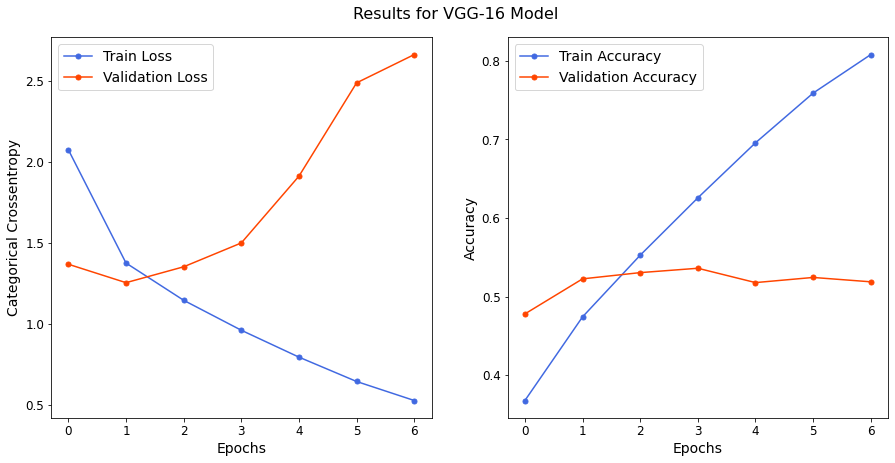

In [ ]:
#Plotting a line chart to visualize the loss and accuracy values by epochs
plot_model_stats(train_loss_vgg16, val_loss_vgg16, train_accuracy_vgg16, val_accuracy_vgg16, 'Results for VGG-16 Model')

In [ ]:
#Accuracy Evaluation
print('\n--------- VGG-16 ----------\n')
vgg16_acc = round(vgg16_final_model.evaluate(test_dataset, verbose=0)[1] * 100, 2)
print("Model Accuracy: {}%".format(vgg16_acc))


--------- VGG-16 ----------

Model Accuracy: 51.19%


## ResNet-50

**ResNet** stands for Residual Network and is a specific type of convolutional neural network (*CNN*) introduced in the 2015 paper “Deep Residual Learning for Image Recognition” by He Kaiming, Zhang Xiangyu, Ren Shaoqing, and Sun Jian.

**ResNet-50** is a 50-layer convolutional neural network (48 convolutional layers, one MaxPool layer, and one average pool layer). Convolutional Neural Networks have a major disadvantage — ‘*Vanishing Gradient Problem*’. During backpropagation, the value of gradient decreases significantly, thus hardly any change comes to weights, so to overcome this ResNet makes use of "***skip connection***" which is a direct connection that skips over some layers of the model. 

In [ ]:
#Importing the ResNet-50 pre-trained model
ResNet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape, classes=num_classes)

for layers in ResNet50_model.layers:
    layers.trainable=False

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
#Defining the final layers of the model
resnet50 = Flatten()(ResNet50_model.output)
resnet50 = Dense(1024,activation='relu')(resnet50)
resnet50 = Dense(512,activation='relu')(resnet50)
resnet50 = Dense(128,activation='relu')(resnet50)
resnet50 = Dense(64,activation='relu')(resnet50)
resnet50 = Dropout(0.5)(resnet50)
resnet50 = Dense(8,activation='softmax')(resnet50)
resnet50_final_model = Model(inputs=ResNet50_model.input, outputs=resnet50)
resnet50_final_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])

resnet50_final_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
#Training the model & saving weights
number_of_epochs = 50
resnet_filepath = '../content/resnet50_weights.h5'
resnet_checkpoint = tf.keras.callbacks.ModelCheckpoint(resnet_filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min')
resnet_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=4, min_lr=0.000002)
callbacklist = [resnet_checkpoint,resnet_early_stopping,reduce_lr]
resnet50_history = resnet50_final_model.fit(train_ds, epochs = number_of_epochs ,validation_data = val_ds,callbacks=callbacklist,verbose=1)

Epoch 1/50
649/649 [==============================] - ETA: 0s - loss: 2.0093 - sparse_categorical_accuracy: 0.3473
Epoch 1: val_loss improved from inf to 1.53761, saving model to ../content/resnet50_weights.h5
649/649 [==============================] - 582s 884ms/step - loss: 2.0093 - sparse_categorical_accuracy: 0.3473 - val_loss: 1.5376 - val_sparse_categorical_accuracy: 0.4049 - lr: 0.0010
Epoch 2/50
649/649 [==============================] - ETA: 0s - loss: 1.5917 - sparse_categorical_accuracy: 0.3901
Epoch 2: val_loss improved from 1.53761 to 1.43390, saving model to ../content/resnet50_weights.h5
649/649 [==============================] - 569s 876ms/step - loss: 1.5917 - sparse_categorical_accuracy: 0.3901 - val_loss: 1.4339 - val_sparse_categorical_accuracy: 0.4207 - lr: 0.0010
Epoch 3/50
649/649 [==============================] - ETA: 0s - loss: 1.4093 - sparse_categorical_accuracy: 0.4342
Epoch 3: val_loss improved from 1.43390 to 1.35235, saving model to ../content/resnet50_w

In [ ]:
#Saving the train and validation loss and accuracy values from ResNet-50
train_loss_resnet50 = resnet50_history.history['loss']
val_loss_resnet50 = resnet50_history.history['val_loss']
train_accuracy_resnet50 = resnet50_history.history['sparse_categorical_accuracy']
val_accuracy_resnet50 = resnet50_history.history['val_sparse_categorical_accuracy']

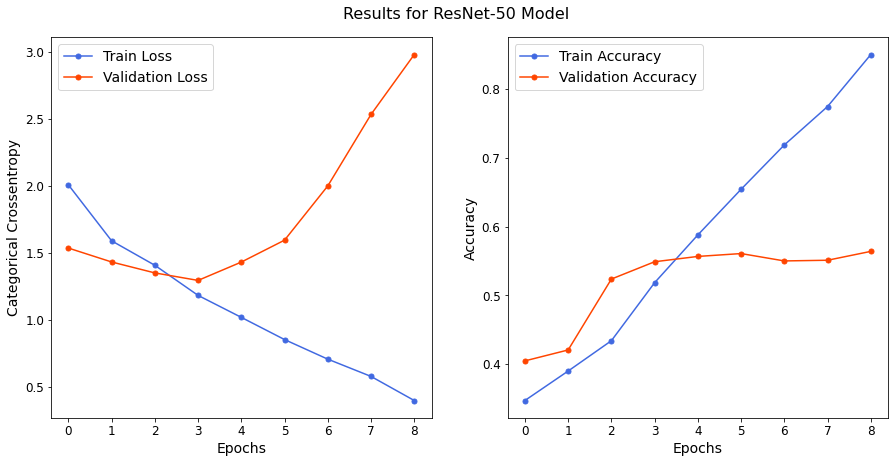

In [ ]:
#Plotting a line chart to visualize the loss and accuracy values by epochs
plot_model_stats(train_loss_resnet50, val_loss_resnet50, train_accuracy_resnet50, val_accuracy_resnet50, 'Results for ResNet-50 Model')

In [ ]:
#Accuracy Evaluation
print('\n--------- ResNet-50 ----------\n')
resnet50_acc = round(resnet50_final_model.evaluate(test_dataset, verbose=0)[1] * 100, 2)
print("Model Accuracy: {}%".format(resnet50_acc))


--------- ResNet-50 ----------

Model Accuracy: 57.23%


## DenseNet-121

**DenseNet** was presented in the paper "*Densely connected convolutional networks*" in 2017 which got best paper award with over 2000 citations. It is jointly invented by Cornwell University, Tsinghua University and Facebook AI Research (FAIR).
  
*Dense Convolutional Network* (**DenseNet**) connects each layer to every other layer in a feed-forward fashion. They alleviate the vanishing-gradient problem, strengthen feature propagation, encourage feature reuse, and substantially reduce the number of parameters.

DenseNet works on the idea that convolutional networks can be substantially deeper, more accurate, and efficient to train if they have shorter connections between layers close to the input and those close to the output.

In [ ]:
DenseNet_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape, classes=num_classes)

for layers in DenseNet_model.layers:
    layers.trainable=False

29084464/29084464 [==============================] - 1s 0us/step


In [ ]:
densenet = Flatten()(DenseNet_model.output)
densenet = Dense(1024,activation='relu')(densenet)
densenet = Dense(512,activation='relu')(densenet)
densenet = Dense(128,activation='relu')(densenet)
densenet = Dense(64,activation='relu')(densenet)
densenet = Dropout(0.5)(densenet)
densenet = Dense(8,activation='softmax')(densenet)
densenet_final_model = Model(inputs=DenseNet_model.input, outputs=densenet)
densenet_final_model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['sparse_categorical_accuracy'])

densenet_final_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_3[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

In [ ]:
number_of_epochs = 50
densenet_filepath = '../content/densenet_weights.h5'
densenet_checkpoint = tf.keras.callbacks.ModelCheckpoint(densenet_filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min')
densenet_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.000002)
callbacklist = [densenet_checkpoint, densenet_early_stopping, reduce_lr]
densenet_history = densenet_final_model.fit(train_ds, epochs = number_of_epochs ,validation_data = val_ds,callbacks=callbacklist,verbose=1)

Epoch 1/50
649/649 [==============================] - ETA: 0s - loss: 2.0052 - sparse_categorical_accuracy: 0.2890
Epoch 1: val_loss improved from inf to 1.73684, saving model to ../content/densenet_weights.h5
649/649 [==============================] - 538s 808ms/step - loss: 2.0052 - sparse_categorical_accuracy: 0.2890 - val_loss: 1.7368 - val_sparse_categorical_accuracy: 0.3781 - lr: 1.0000e-04
Epoch 2/50
649/649 [==============================] - ETA: 0s - loss: 1.8378 - sparse_categorical_accuracy: 0.3330
Epoch 2: val_loss improved from 1.73684 to 1.65226, saving model to ../content/densenet_weights.h5
649/649 [==============================] - 515s 792ms/step - loss: 1.8378 - sparse_categorical_accuracy: 0.3330 - val_loss: 1.6523 - val_sparse_categorical_accuracy: 0.3993 - lr: 1.0000e-04
Epoch 3/50
649/649 [==============================] - ETA: 0s - loss: 1.7320 - sparse_categorical_accuracy: 0.3651
Epoch 3: val_loss improved from 1.65226 to 1.55477, saving model to ../content/de

In [ ]:
#Saving the train and validation loss and accuracy values from DenseNet-121
train_loss_densenet = densenet_history.history['loss']
val_loss_densenet = densenet_history.history['val_loss']
train_accuracy_densenet = densenet_history.history['sparse_categorical_accuracy']
val_accuracy_densenet = densenet_history.history['val_sparse_categorical_accuracy']

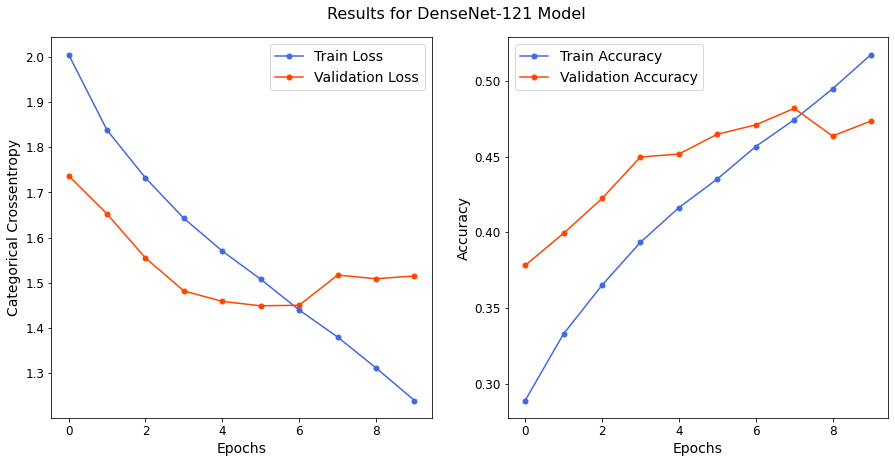

In [ ]:
#Plotting a line chart to visualize the loss and accuracy values by epochs
plot_model_stats(train_loss_densenet, val_loss_densenet, train_accuracy_densenet, val_accuracy_densenet, 'Results for DenseNet-121 Model')

In [ ]:
#Accuracy Evaluation
print('\n--------- DenseNet-121 ----------\n')
densenet_acc = round(densenet_final_model.evaluate(test_dataset, verbose=0)[1] * 100, 2)
print("Model Accuracy: {}%".format(densenet_acc))


--------- DenseNet-121 ----------

Model Accuracy: 47.27%


## EfficientNet

In 2019 *Google* released a paper that dealt with a new family of **CNN**s called **EfficientNet**. These **CNN**s not only provide better accuracy but also improve the efficiency of the models by reducing the parameters and **FLOPS** (*Floating Point Operations Per Second*).  

The main contributions of the paper are:  

 *  Designing a simple mobile-size baseline architecture: **EfficientNet-B0**
 *  Providing an effective **compound scaling** method for increasing the model size to achieve maximum accuracy gains  

<br/>

A convolutional neural network can be scaled in 3 dimensions:

 *  **Depth**: It corresponds to the number of layers in a network.
 Increasing the depth, by stacking more convolutional layers, allows the network to learn more complex features. However deeper networks tend to suffer from vanishing gradients and become difficult to train. There are some different techniques for reducing this issue but the accuracy gains by only increasing the depth of the network quickly saturate. For instance ResNet-1000 provides the same accuracy as ResNet-100 despite all the extra layers.

 * **Width**: It's associated with the number of neurons in a layer and the number of filters in a convolutional layer.  
 Scaling the width of the networks allows layers to learn more fine grained features. However increasing width prevents the network from learning complex features, resulting in diminishing accuracy gains. 

 * **Resolution**: It's simply the height and width of the input image.  
 Higher input resolution provides a greater detail about the image and hence enhances the model's ability to reason about smaller objects and extract finer patterns. But like the other scaling methods, this too provides limited accuracy gain on its own.

<br/>

This implies that the scaling of network for increase in accuracy should be contributed in part by a combination of the three dimensions: all layers must be scaled uniformly with constant ratio.  
This is the core idea of **EfficientNet**. 



### EfficientNet-B0

This is the first version of **EfficientNet**, it has 237 layers and the input shape is 224x224

In [ ]:
#Importing the EfficientNetB0 pre-trained model
EfficientB0 = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape, classes=num_classes)

for layers in EfficientB0.layers:
    layers.trainable=False

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
#Defining the final layers of the model
efficientB0 = Flatten()(EfficientB0.output)
efficientB0 = Dense(1024,activation='relu')(efficientB0)
efficientB0 = Dense(512,activation='relu')(efficientB0)
efficientB0 = Dense(128,activation='relu')(efficientB0)
efficientB0 = Dense(64,activation='relu')(efficientB0)
efficientB0 = Dropout(0.5)(efficientB0)
efficientB0 = Dense(8,activation='softmax')(efficientB0)
efficientB0_final_model = Model(inputs=EfficientB0.input, outputs=efficientB0)
efficientB0_final_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])

efficientB0_final_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_4[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['normalization[0][0]']    

In [ ]:
#Training the model & saving weights
number_of_epochs = 50
efficientB0_filepath = '../content/efficientB0_weights.h5'
efficientB0_checkpoint = tf.keras.callbacks.ModelCheckpoint(efficientB0_filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min')
efficientB0_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=4, min_lr=0.000002)
callbacklist = [efficientB0_checkpoint, efficientB0_early_stopping, reduce_lr]
efficientB0_history = efficientB0_final_model.fit(train_ds, epochs = number_of_epochs, validation_data = val_ds, callbacks=callbacklist, verbose=1)

Epoch 1/50
649/649 [==============================] - ETA: 0s - loss: 1.4303 - sparse_categorical_accuracy: 0.4667
Epoch 1: val_loss improved from inf to 1.15602, saving model to ../content/efficientB0_weights.h5
649/649 [==============================] - 358s 538ms/step - loss: 1.4303 - sparse_categorical_accuracy: 0.4667 - val_loss: 1.1560 - val_sparse_categorical_accuracy: 0.5468 - lr: 0.0010
Epoch 2/50
649/649 [==============================] - ETA: 0s - loss: 1.0604 - sparse_categorical_accuracy: 0.5789
Epoch 2: val_loss did not improve from 1.15602
649/649 [==============================] - 347s 534ms/step - loss: 1.0604 - sparse_categorical_accuracy: 0.5789 - val_loss: 1.2537 - val_sparse_categorical_accuracy: 0.5650 - lr: 0.0010
Epoch 3/50
649/649 [==============================] - ETA: 0s - loss: 0.8535 - sparse_categorical_accuracy: 0.6637
Epoch 3: val_loss did not improve from 1.15602
649/649 [==============================] - 350s 538ms/step - loss: 0.8535 - sparse_categori

In [ ]:
#Saving the train and validation loss and accuracy values from EfficientNet-B0
train_loss_efficientB0 = efficientB0_history.history['loss']
val_loss_efficientB0 = efficientB0_history.history['val_loss']
train_accuracy_efficientB0 = efficientB0_history.history['sparse_categorical_accuracy']
val_accuracy_efficientB0 = efficientB0_history.history['val_sparse_categorical_accuracy']

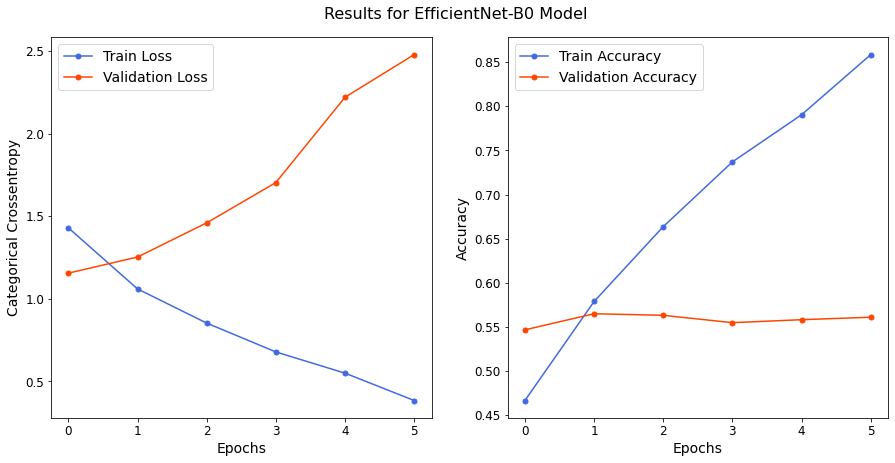

In [ ]:
#Plotting a line chart to visualize the loss and accuracy values by epochs
plot_model_stats(train_loss_efficientB0, val_loss_efficientB0, train_accuracy_efficientB0, val_accuracy_efficientB0, 'Results for EfficientNet-B0 Model')

In [ ]:
#Accuracy Evaluation
print('\n--------- EfficientNet-B0 ----------\n')
efficientB0_acc = round(efficientB0_final_model.evaluate(test_dataset, verbose=0)[1] * 100, 2)
print("Model Accuracy: {}%".format(efficientB0_acc))


--------- EfficientNet-B0 ----------

Model Accuracy: 56.88%


## Results

In [ ]:
#Saving model weights on Google Drive 
filename = '../content/drive/MyDrive/Age_Detection_Project/Models'
shutil.make_archive(filename, 'zip', '../content/Models')

'/content/drive/MyDrive/Age_Detection_Project/Models.zip'

In [ ]:
#Defining function to get percentage string from a number 
def perc(num):
  return str(round(float(num)*100, 2))+'%'

#Building the table of the result
table = [['\033[1m#\033[0m', '\033[1mModel Description\033[0m', '\033[1mTrain Loss\033[0m', '\033[1mVal Loss\033[0m', '\033[1mTrain Acc\033[0m', '\033[1mVal Acc\033[0m', '\033[1mTest Acc\033[0m'], 
         ['1', 'VGG-16', str(round(train_loss_vgg16[-1], 3)), round(val_loss_vgg16[-1], 3), perc(train_accuracy_vgg16[-1]), perc(val_accuracy_vgg16[-1]), perc(vgg16_acc/100)],
         ['2','ResNet-50', round(train_loss_resnet50[-1], 3), round(val_loss_resnet50[-1], 3), perc(train_accuracy_resnet50[-1]), perc(val_accuracy_resnet50[-1]), perc(resnet50_acc/100)],
         ['3','DenseNet-121', round(train_loss_densenet[-1], 3), round(val_loss_densenet[-1], 3), perc(train_accuracy_densenet[-1]), perc(val_accuracy_densenet[-1]), perc(densenet_acc/100)],
         ['4','EfficientNet-B0', round(train_loss_efficientB0[-1], 3), round(val_loss_efficientB0[-1], 3), perc(train_accuracy_efficientB0[-1]), perc(val_accuracy_efficientB0[-1]), perc(efficientB0_acc/100)]
        ]

#Printing the table
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒═════╤═════════════════════╤══════════════╤════════════╤═════════════╤═══════════╤════════════╕
│   # │ Model Description   │   Train Loss │   Val Loss │ Train Acc   │ Val Acc   │ Test Acc   │
╞═════╪═════════════════════╪══════════════╪════════════╪═════════════╪═══════════╪════════════╡
│   1 │ VGG-16              │        0.528 │      2.662 │ 80.79%      │ 51.88%    │ 51.19%     │
├─────┼─────────────────────┼──────────────┼────────────┼─────────────┼───────────┼────────────┤
│   2 │ ResNet-50           │        0.401 │      2.981 │ 85.01%      │ 56.4%     │ 57.23%     │
├─────┼─────────────────────┼──────────────┼────────────┼─────────────┼───────────┼────────────┤
│   3 │ DenseNet-121        │        1.239 │      1.515 │ 51.73%      │ 47.34%    │ 47.27%     │
├─────┼─────────────────────┼──────────────┼────────────┼─────────────┼───────────┼────────────┤
│   4 │ EfficientNet-B0     │        0.385 │      2.479 │ 85.86%      │ 56.1%     │ 56.88%     │
╘═════╧═════════════════════╧═